In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
import torch.utils.data as data
from tqdm.notebook import tqdm
from copy import deepcopy
from random import shuffle


In [2]:
transform = transforms.Compose(
[transforms.ToTensor(),
 transforms.Normalize(0.1307, 0.3081),
 transforms.Lambda(lambda x: torch.flatten(x))])

mnistTrainSet = datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)
mnistTestSet = datasets.MNIST(root='./data', train=False,
                                    download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnistTrainSet, batch_size=16,
                                      shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnistTestSet, batch_size=16,
                                      shuffle=True, num_workers=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

100%|██████████| 9912422/9912422 [00:00<00:00, 227978259.47it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 119699302.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 120042550.10it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1699119.58it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# @title
TRAIN_NUM_SAMPLES = 10
TEST_NUM_SAMPLES = 50
EPSILON = 1e-8  # Small value to avoid divide-by-zero and log(zero) problems


def empty_parameter_like(t):
    return nn.Parameter(torch.empty_like(t, requires_grad=True))

def concatenate_flattened(tensor_list) -> torch.Tensor:
    """
    Given list of tensors, flattens each and concatenates their values.
    """
    return torch.cat([torch.reshape(t, (-1,)) for t in tensor_list])

def task_subset(data: Dataset, task_ids: torch.Tensor, task: int, ) -> torch.Tensor:
    idx_list = torch.arange(0, len(task_ids))[task_ids == task]
    return Subset(data, idx_list)

def class_accuracy(pred: torch.Tensor, true: torch.Tensor) -> float:
    """
    Computes the percentage class accuracy of the predictions, given the correct
    class labels.

    Args:
        pred: the class predictions made by a model
        true: the ground truth classes of the sample
    Returns:
        Classification accuracy of the predictions w.r.t. the ground truth labels
    """
    return 100 * (pred.int() == true.int()).sum().item() / len(true)



In [4]:
# @title
class DiscriminativeVCL(nn.Module):
    """ A Bayesian multi-head neural network which updates its parameters using variational inference."""

    def __init__(self, in_size: int, out_size: int, layer_width: int,
                 n_hidden_layers: int, n_heads: int, initial_posterior_var: int):
        super().__init__()
        self.input_size = in_size
        self.out_size = out_size
        self.n_hidden_layers = n_hidden_layers
        self.layer_width = layer_width
        self.n_heads = n_heads

        print("Number of heads:", n_heads)

        self.prior, self.posterior = None, None
        self.head_prior, self.head_posterior = None, None

        self._init_variables(initial_posterior_var)

    def to(self, *args, **kwargs):
        """
        Our prior tensors are registered as buffers but the way we access them indirectly (through tuple attributes
        on the model) is causing problems because when we use `.to()` to move the model to a new device, the prior
        tensors get moved (because they're registered as buffers) but the references in the tuples don't get updated
        to point to the new moved tensors. This has no effect when running just on a cpu but breaks the model when
        trying to run on a gpu. There are a million nicer ways of working around this problem, but for now the easiest
        thing is to do this: override the `.to()` method and manually update our references to prior tensors.
        """
        self = super().to(*args, **kwargs)

        (prior_w_means, prior_w_log_vars), (prior_b_means, prior_b_log_vars) = self.prior

        prior_w_means = [t.to(*args, **kwargs) for t in prior_w_means]
        prior_w_log_vars = [t.to(*args, **kwargs) for t in prior_w_log_vars]
        prior_b_means = [t.to(*args, **kwargs) for t in prior_b_means]
        prior_b_log_vars = [t.to(*args, **kwargs) for t in prior_b_log_vars]

        self.prior = (prior_w_means, prior_w_log_vars), (prior_b_means, prior_b_log_vars)

        (head_prior_w_means, head_prior_w_log_vars), (head_prior_b_means, head_prior_b_log_vars) = self.head_prior
        head_prior_w_means = [t.to(*args, **kwargs) for t in head_prior_w_means]
        head_prior_w_log_vars = [t.to(*args, **kwargs) for t in head_prior_w_log_vars]
        head_prior_b_means = [t.to(*args, **kwargs) for t in head_prior_b_means]
        head_prior_b_log_vars = [t.to(*args, **kwargs) for t in head_prior_b_log_vars]

        self.head_prior = (head_prior_w_means, head_prior_w_log_vars), (head_prior_b_means, head_prior_b_log_vars)
        return self

    def forward(self, x, head):
        """ Forward pass of the model on an input. """
        # sample layer parameters from posterior distribution
        (w_means, w_log_vars), (b_means, b_log_vars) = self.posterior
        (head_w_means, head_w_log_vars), (head_b_means, head_b_log_vars) = self.head_posterior

        sampled_layers = self._sample_parameters_normal_dist(w_means, b_means, w_log_vars, b_log_vars)
        sampled_head_layers = self._sample_parameters_normal_dist(head_w_means, head_b_means, head_w_log_vars,
                                                                  head_b_log_vars)

        # Apply each layer with its sampled weights and biases
        for weight, bias in sampled_layers:
            x = F.relu(x @ weight + bias)

        head_weight, head_bias = list(sampled_head_layers)[head]
        x = x @ head_weight + head_bias

        return x

    def vcl_loss(self, x, y, head, task_size, num_samples=TRAIN_NUM_SAMPLES) -> torch.Tensor:
        """
        Returns the loss of the model, as described in equation 4 of the Variational
        Continual Learning paper (https://arxiv.org/abs/1710.10628).
        """
        return self._calculate_kl_term(head).cpu() / task_size - self._log_prob(x, y, head, num_samples)

    def point_estimate_loss(self, x, y, head=0):
        """
        Returns a loss defined in terms of a simplified forward pass that
        doesn't use sampling, and so uses the posterior means but not the
        variances. Used as part of model initialisation to optimise the
        posterior means to point-estimates for the first head.
        """
        (w_means, _), (b_means, _) = self.posterior
        (head_w_means, _), (head_b_means, _) = self.head_posterior

        for weight, bias in zip(w_means, b_means):
            x = F.relu(x @ weight + bias)

        x = x @ head_w_means[head] + head_b_means[head]

        return nn.CrossEntropyLoss()(x, y)

    def prediction(self, x, head, num_samples=TEST_NUM_SAMPLES):
        """Returns an integer between 0 and self.out_size"""
        outputs = torch.empty(num_samples, len(x), self.out_size)
        for i in range(num_samples):
            outputs[i] = nn.Softmax(dim=1)(self.forward(x, head))

        predictions = outputs.mean(dim=0)

        return torch.argmax(predictions, dim=1)

    def reset_for_new_task(self, head):
        """
        Called after completion of a task, to reset state for the next task
        """
        # Set the value of the prior to be the current value of the posterior
        (prior_w_means, prior_w_log_vars), (prior_b_means, prior_b_log_vars) = self.prior
        (post_w_means, post_w_log_vars), (post_b_means, post_b_log_vars) = self.posterior
        for i in range(self.n_hidden_layers):
            prior_w_means[i].data.copy_(post_w_means[i].data)
            prior_w_log_vars[i].data.copy_(post_w_log_vars[i].data)
            prior_b_means[i].data.copy_(post_b_means[i].data)
            prior_b_log_vars[i].data.copy_(post_b_log_vars[i].data)

        # set the value of the head prior to be the current value of the posterior
        (head_prior_w_means, head_prior_w_log_vars), (head_prior_b_means, head_prior_b_log_vars) = self.head_prior
        (head_posterior_w_means, head_posterior_w_log_vars), (
            head_posterior_b_means, head_posterior_b_log_vars) = self.head_posterior
        head_prior_w_means[head].data.copy_(head_posterior_w_means[head].data)
        head_prior_w_log_vars[head].data.copy_(head_posterior_w_log_vars[head].data)
        head_prior_b_means[head].data.copy_(head_posterior_b_means[head].data)
        head_prior_b_log_vars[head].data.copy_(head_posterior_b_log_vars[head].data)

    def _calculate_kl_term(self, head):
        """
        Calculates and returns the KL divergence of the new posterior and the previous
        iteration's posterior. See equation L3, slide 14.
        """
        # Prior
        ((prior_w_means, prior_w_log_vars), (prior_b_means, prior_b_log_vars)) = self.prior
        ((head_prior_w_means, head_prior_w_log_vars),
         (head_prior_b_means, head_prior_b_log_vars)) = self.head_prior

        prior_means = concatenate_flattened(
            prior_w_means + head_prior_w_means[head:head + 1] +
            prior_b_means + head_prior_b_means[head:head + 1])
        prior_log_vars = concatenate_flattened(
            prior_w_log_vars + head_prior_w_log_vars[head:head + 1] +
            prior_b_log_vars + head_prior_b_log_vars[head:head + 1])
        prior_vars = torch.exp(prior_log_vars)

        # Posterior
        ((post_w_means, post_w_log_vars), (post_b_means, post_b_log_vars)) = self.posterior
        ((head_post_w_means, head_post_w_log_vars),
         (head_post_b_means, head_post_b_log_vars)) = self.head_posterior

        post_means = concatenate_flattened(
            post_w_means + head_post_w_means[head:head + 1] +
            post_b_means + head_post_b_means[head:head + 1])
        post_log_vars = concatenate_flattened(
            post_w_log_vars + head_post_w_log_vars[head:head + 1] +
            post_b_log_vars + head_post_b_log_vars[head:head + 1])
        post_vars = torch.exp(post_log_vars)

        # Calculate KL for individual normal distributions over parameters
        kl_elementwise = \
            post_vars / (prior_vars + EPSILON) + \
            torch.pow(prior_means - post_means, 2) / (prior_vars + EPSILON) \
            - 1 + prior_log_vars - post_log_vars

        # Sum KL over all parameters
        return 0.5 * kl_elementwise.sum()

    def _log_prob(self, x, y, head, num_samples):
        outputs = [self.forward(x, head) for _ in range(num_samples)]
        return - nn.CrossEntropyLoss()(torch.cat(outputs), y.repeat(num_samples).view(-1))

    def _sample_parameters_normal_dist(self, w_means, b_means, w_log_vars, b_log_vars):
        # sample weights and biases from normal distributions
        sampled_weights, sampled_bias = [], []
        for layer_n in range(len(w_means)):
            w_epsilons = torch.randn_like(w_means[layer_n])
            b_epsilons = torch.randn_like(b_means[layer_n])
            sampled_weights.append(w_means[layer_n] + w_epsilons * torch.exp(0.5 * w_log_vars[layer_n]))
            sampled_bias.append(b_means[layer_n] + b_epsilons * torch.exp(0.5 * b_log_vars[layer_n]))
        return zip(sampled_weights, sampled_bias)

    def _init_variables(self, initial_posterior_var):
        """
        Initializes the model's prior and posterior weights / biases to their initial
        values. This method is called once on model creation. The model prior is registered
        as a persistent part of the model state which should not be modified, while the
        initial posterior is registered as a model parameter to be optimized.

        To avoid negative variances, we do not store parameter variances directly; instead
        we store the logarithm of each variance, and apply the exponential as needed in the
        forward pass.
        """
        # The initial prior over the parameters has zero mean, unit variance (i.e. log variance 0)
        prior_w_means = [torch.zeros(self.input_size, self.layer_width)] + \
                        [torch.zeros(self.layer_width, self.layer_width) for _ in range(self.n_hidden_layers - 1)]
        prior_w_log_vars = [torch.zeros_like(t) for t in prior_w_means]
        prior_b_means = [torch.zeros(self.layer_width) for _ in range(self.n_hidden_layers)]
        prior_b_log_vars = [torch.zeros_like(t) for t in prior_b_means]

        self.prior = ((prior_w_means, prior_w_log_vars), (prior_b_means, prior_b_log_vars))

        head_prior_w_means = [torch.zeros(self.layer_width, self.out_size) for t in range(self.n_heads)]
        head_prior_w_log_vars = [torch.zeros_like(t) for t in head_prior_w_means]
        head_prior_b_means = [torch.zeros(self.out_size) for t in range(self.n_heads)]
        head_prior_b_log_vars = [torch.zeros_like(t) for t in head_prior_b_means]

        self.head_prior = ((head_prior_w_means, head_prior_w_log_vars), (head_prior_b_means, head_prior_b_log_vars))

        posterior_w_means = [empty_parameter_like(t) for t in prior_w_means]
        posterior_w_log_vars = [empty_parameter_like(t) for t in prior_w_log_vars]
        posterior_b_means = [empty_parameter_like(t) for t in prior_b_means]
        posterior_b_log_vars = [empty_parameter_like(t) for t in prior_b_log_vars]

        self.posterior = ((posterior_w_means, posterior_w_log_vars), (posterior_b_means, posterior_b_log_vars))

        head_posterior_w_means = [empty_parameter_like(t) for t in head_prior_w_means]
        head_posterior_w_log_vars = [empty_parameter_like(t) for t in head_prior_w_log_vars]
        head_posterior_b_means = [empty_parameter_like(t) for t in head_prior_b_means]
        head_posterior_b_log_vars = [empty_parameter_like(t) for t in head_prior_b_log_vars]

        self.head_posterior = \
            ((head_posterior_w_means, head_posterior_w_log_vars),
             (head_posterior_b_means, head_posterior_b_log_vars))

        # Initialise the posterior means with a normal distribution. Note that
        # prior to training we will run a procedure to optimise these values to
        # point-estimates of the parameters for the first task.
        for t in posterior_w_means + posterior_b_means + head_posterior_w_means + head_posterior_b_means:
            torch.nn.init.normal_(t, mean=0, std=0.1)

        # Initialise the posterior variances with the given constant value.
        for t in posterior_w_log_vars + posterior_b_log_vars + head_posterior_w_log_vars + head_posterior_b_log_vars:
            torch.nn.init.constant_(t, math.log(initial_posterior_var))

        # Finally, we register the prior and the posterior with the nn.Module.
        # The prior values are registered as buffers, which indicates to PyTorch
        # that they represent persistent state which should not be updated by
        # the optimizer. The posteriors are registered as parameters, which on
        # the other hand are to be modified by the optimizer.
        for i in range(self.n_hidden_layers):
            self.register_buffer("prior_w_means_" + str(i), prior_w_means[i])
            self.register_buffer("prior_w_log_vars_" + str(i), prior_w_log_vars[i])
            self.register_buffer("prior_b_means_" + str(i), prior_b_means[i])
            self.register_buffer("prior_b_log_vars_" + str(i), prior_b_log_vars[i])

        for i in range(self.n_heads):
            self.register_buffer("head_prior_w_means_" + str(i), head_prior_w_means[i])
            self.register_buffer("head_prior_w_log_vars_" + str(i), head_prior_w_log_vars[i])
            self.register_buffer("head_prior_b_means_" + str(i), head_prior_b_means[i])
            self.register_buffer("head_prior_b_log_vars_" + str(i), head_prior_b_log_vars[i])

        for i in range(self.n_hidden_layers):
            self.register_parameter("posterior_w_means_" + str(i), posterior_w_means[i])
            self.register_parameter("posterior_w_log_vars_" + str(i), posterior_w_log_vars[i])
            self.register_parameter("posterior_b_means_" + str(i), posterior_b_means[i])
            self.register_parameter("posterior_b_log_vars_" + str(i), posterior_b_log_vars[i])

        for i in range(self.n_heads):
            self.register_parameter("head_posterior_w_means_" + str(i), head_posterior_w_means[i])
            self.register_parameter("head_posterior_w_log_vars_" + str(i), head_posterior_w_log_vars[i])
            self.register_parameter("head_posterior_b_means_" + str(i), head_posterior_b_means[i])
            self.register_parameter("head_posterior_b_log_vars_" + str(i), head_posterior_b_log_vars[i])

    def _mean_posterior_variance(self):
        """
        Return the mean posterior variance for logging purposes.
        Excludes the head layer.
        """
        ((_, posterior_w_log_vars), (_, posterior_b_log_vars)) = self.posterior
        posterior_log_vars = torch.cat([torch.reshape(t, (-1,)) for t in posterior_w_log_vars] + posterior_b_log_vars)
        posterior_vars = torch.exp(posterior_log_vars)
        return torch.mean(posterior_vars).item()

In [ ]:
# @title
class DiscriminativeVCL_withLowRank(nn.Module):
    """ A Bayesian multi-head neural network which updates its parameters using variational inference."""

    def __init__(self, in_size: int, out_size: int, layer_width: int,
                 n_hidden_layers: int, r: list, A_std: float, n_heads: int, initial_posterior_var: int):
        super().__init__()
        self.input_size = in_size
        self.out_size = out_size
        self.n_hidden_layers = n_hidden_layers
        self.layer_width = layer_width
        self.r = r
        self.A_std = A_std
        self.n_heads = n_heads

        print("Number of heads:", n_heads)

        self.prior, self.posterior = None, None
        self.head_prior, self.head_posterior = None, None

        self.first_task = True

        self._init_variables(initial_posterior_var)

    def to(self, *args, **kwargs):
        """
        Our prior tensors are registered as buffers but the way we access them indirectly (through tuple attributes
        on the model) is causing problems because when we use `.to()` to move the model to a new device, the prior
        tensors get moved (because they're registered as buffers) but the references in the tuples don't get updated
        to point to the new moved tensors. This has no effect when running just on a cpu but breaks the model when
        trying to run on a gpu. There are a million nicer ways of working around this problem, but for now the easiest
        thing is to do this: override the `.to()` method and manually update our references to prior tensors.
        """
        self = super().to(*args, **kwargs)

        (prior_w_means, prior_w_log_vars), (prior_b_means, prior_b_log_vars) = self.prior

        prior_w_means = [t.to(*args, **kwargs) for t in prior_w_means]
        prior_w_log_vars = [t.to(*args, **kwargs) for t in prior_w_log_vars]
        prior_b_means = [t.to(*args, **kwargs) for t in prior_b_means]
        prior_b_log_vars = [t.to(*args, **kwargs) for t in prior_b_log_vars]

        self.prior = (prior_w_means, prior_w_log_vars), (prior_b_means, prior_b_log_vars)

        (head_prior_w_means, head_prior_w_log_vars), (head_prior_b_means, head_prior_b_log_vars) = self.head_prior
        head_prior_w_means = [t.to(*args, **kwargs) for t in head_prior_w_means]
        head_prior_w_log_vars = [t.to(*args, **kwargs) for t in head_prior_w_log_vars]
        head_prior_b_means = [t.to(*args, **kwargs) for t in head_prior_b_means]
        head_prior_b_log_vars = [t.to(*args, **kwargs) for t in head_prior_b_log_vars]

        self.head_prior = (head_prior_w_means, head_prior_w_log_vars), (head_prior_b_means, head_prior_b_log_vars)
        return self

    def forward(self, x, head):
        """ Forward pass of the model on an input. """
        # sample layer parameters from posterior distribution
        if self.first_task:
          (w_means, w_log_vars), (b_means, b_log_vars) = self.posterior
        else:
          LoRA_w_means = [B@A for (A,B) in zip (self.LoRA_w_means_Amat, self.LoRA_w_means_Bmat)]
          LoRA_w_log_vars = [B@A for (A,B) in zip (self.LoRA_w_log_vars_Amat, self.LoRA_w_log_vars_Bmat)]
          (w_means, w_log_vars), (b_means, b_log_vars) = self.prior
          w_means = [prior_means + LoRA_means.T for (prior_means, LoRA_means ) in zip(w_means, LoRA_w_means)]
          w_log_vars = [prior_log_var + LoRA_log_var.T for (prior_log_var, LoRA_log_var ) in zip(w_log_vars, LoRA_w_log_vars)]


        (head_w_means, head_w_log_vars), (head_b_means, head_b_log_vars) = self.head_posterior

        sampled_layers = self._sample_parameters_normal_dist(w_means, b_means, w_log_vars, b_log_vars)
        sampled_head_layers = self._sample_parameters_normal_dist(head_w_means, head_b_means, head_w_log_vars,
                                                                  head_b_log_vars)

        # Apply each layer with its sampled weights and biases
        for weight, bias in sampled_layers:
            x = F.relu(x @ weight + bias)

        head_weight, head_bias = list(sampled_head_layers)[head]
        x = x @ head_weight + head_bias

        return x

    def vcl_loss(self, x, y, head, task_size, num_samples=TRAIN_NUM_SAMPLES) -> torch.Tensor:
        """
        Returns the loss of the model, as described in equation 4 of the Variational
        Continual Learning paper (https://arxiv.org/abs/1710.10628).
        """
        return self._calculate_kl_term(head).cpu() / task_size - self._log_prob(x, y, head, num_samples)

    def point_estimate_loss(self, x, y, head=0):
        """
        Returns a loss defined in terms of a simplified forward pass that
        doesn't use sampling, and so uses the posterior means but not the
        variances. Used as part of model initialisation to optimise the
        posterior means to point-estimates for the first head.
        """
        (w_means, _), (b_means, _) = self.posterior
        (head_w_means, _), (head_b_means, _) = self.head_posterior

        for weight, bias in zip(w_means, b_means):
            x = F.relu(x @ weight + bias)

        x = x @ head_w_means[head] + head_b_means[head]

        return nn.CrossEntropyLoss()(x, y)

    def prediction(self, x, head, num_samples=TEST_NUM_SAMPLES):
        """Returns an integer between 0 and self.out_size"""
        outputs = torch.empty(num_samples, len(x), self.out_size)
        for i in range(num_samples):
            outputs[i] = nn.Softmax(dim=1)(self.forward(x, head))

        predictions = outputs.mean(dim=0)

        return torch.argmax(predictions, dim=1)

    def reset_for_new_task(self, head):
        """
        Called after completion of a task, to reset state for the next task
        """
        # Set the value of the prior to be the current value of the posterior
        (prior_w_means, prior_w_log_vars), (prior_b_means, prior_b_log_vars) = self.prior
        (post_w_means, post_w_log_vars), (post_b_means, post_b_log_vars) = self.posterior
        for i in range(self.n_hidden_layers):
            prior_w_means[i].data.copy_(post_w_means[i].data)
            prior_w_log_vars[i].data.copy_(post_w_log_vars[i].data)
            prior_b_means[i].data.copy_(post_b_means[i].data)
            prior_b_log_vars[i].data.copy_(post_b_log_vars[i].data)

        # set the value of the head prior to be the current value of the posterior
        (head_prior_w_means, head_prior_w_log_vars), (head_prior_b_means, head_prior_b_log_vars) = self.head_prior
        (head_posterior_w_means, head_posterior_w_log_vars), (
            head_posterior_b_means, head_posterior_b_log_vars) = self.head_posterior
        head_prior_w_means[head].data.copy_(head_posterior_w_means[head].data)
        head_prior_w_log_vars[head].data.copy_(head_posterior_w_log_vars[head].data)
        head_prior_b_means[head].data.copy_(head_posterior_b_means[head].data)
        head_prior_b_log_vars[head].data.copy_(head_posterior_b_log_vars[head].data)

        self.first_task = False
        self._init_LoRA_variables()

    def _calculate_kl_term(self, head):
        """
        Calculates and returns the KL divergence of the new posterior and the previous
        iteration's posterior. See equation L3, slide 14.
        """
        # Prior
        ((prior_w_means, prior_w_log_vars), (prior_b_means, prior_b_log_vars)) = self.prior
        ((head_prior_w_means, head_prior_w_log_vars),
         (head_prior_b_means, head_prior_b_log_vars)) = self.head_prior

        prior_means = concatenate_flattened(
            prior_w_means + head_prior_w_means[head:head + 1] +
            prior_b_means + head_prior_b_means[head:head + 1])
        prior_log_vars = concatenate_flattened(
            prior_w_log_vars + head_prior_w_log_vars[head:head + 1] +
            prior_b_log_vars + head_prior_b_log_vars[head:head + 1])
        prior_vars = torch.exp(prior_log_vars)

        # Posterior
        ((post_w_means, post_w_log_vars), (post_b_means, post_b_log_vars)) = self.posterior
        ((head_post_w_means, head_post_w_log_vars),
         (head_post_b_means, head_post_b_log_vars)) = self.head_posterior

        post_means = concatenate_flattened(
            post_w_means + head_post_w_means[head:head + 1] +
            post_b_means + head_post_b_means[head:head + 1])
        post_log_vars = concatenate_flattened(
            post_w_log_vars + head_post_w_log_vars[head:head + 1] +
            post_b_log_vars + head_post_b_log_vars[head:head + 1])
        post_vars = torch.exp(post_log_vars)

        # Calculate KL for individual normal distributions over parameters
        kl_elementwise = \
            post_vars / (prior_vars + EPSILON) + \
            torch.pow(prior_means - post_means, 2) / (prior_vars + EPSILON) \
            - 1 + prior_log_vars - post_log_vars

        # Sum KL over all parameters
        return 0.5 * kl_elementwise.sum()

    def _log_prob(self, x, y, head, num_samples):
        outputs = [self.forward(x, head) for _ in range(num_samples)]
        return - nn.CrossEntropyLoss()(torch.cat(outputs), y.repeat(num_samples).view(-1))

    def _sample_parameters_normal_dist(self, w_means, b_means, w_log_vars, b_log_vars):
        # sample weights and biases from normal distributions
        sampled_weights, sampled_bias = [], []
        for layer_n in range(len(w_means)):
            w_epsilons = torch.randn_like(w_means[layer_n])
            b_epsilons = torch.randn_like(b_means[layer_n])
            sampled_weights.append(w_means[layer_n] + w_epsilons * torch.exp(0.5 * w_log_vars[layer_n]))
            sampled_bias.append(b_means[layer_n] + b_epsilons * torch.exp(0.5 * b_log_vars[layer_n]))
        return zip(sampled_weights, sampled_bias)

    def _init_LoRA_variables(self):
        print("Initialising LoRA variables")
        self.LoRA_w_means_Amat = [empty_parameter_like(torch.zeros(self.r[0], self.input_size).to(device))] + \
                             [empty_parameter_like(torch.zeros(self.r[i+1], self.layer_width).to(device)) for i in range(self.n_hidden_layers - 1)]
        self.LoRA_w_means_Bmat = [nn.Parameter(torch.zeros(self.layer_width, self.r[i], requires_grad=True).to(device)) for i in range(self.n_hidden_layers)]

        self.LoRA_w_log_vars_Amat = [empty_parameter_like(torch.zeros(self.r[0], self.input_size).to(device))] + \
                             [empty_parameter_like(torch.zeros(self.r[i+1], self.layer_width).to(device)) for i in range(self.n_hidden_layers - 1)]
        self.LoRA_w_log_vars_Bmat = [nn.Parameter(torch.zeros(self.layer_width, self.r[i], requires_grad=True).to(device)) for i in range(self.n_hidden_layers)]

        for t in (self.LoRA_w_means_Amat + self.LoRA_w_log_vars_Amat):
              torch.nn.init.normal_(t, mean=0, std=self.A_std)

        for i in range(self.n_hidden_layers):
            self.register_parameter("LoRA_w_means_Amat" + str(i), self.LoRA_w_means_Amat[i])
            self.register_parameter("LoRA_w_means_Bmat" + str(i), self.LoRA_w_means_Bmat[i])
            self.register_parameter("LoRA_w_log_vars_Amat" + str(i), self.LoRA_w_log_vars_Amat[i])
            self.register_parameter("LoRA_w_log_vars_Bmat" + str(i), self.LoRA_w_log_vars_Bmat[i])


    def _init_variables(self, initial_posterior_var):
        """
        Initializes the model's prior and posterior weights / biases to their initial
        values. This method is called once on model creation. The model prior is registered
        as a persistent part of the model state which should not be modified, while the
        initial posterior is registered as a model parameter to be optimized.

        To avoid negative variances, we do not store parameter variances directly; instead
        we store the logarithm of each variance, and apply the exponential as needed in the
        forward pass.
        """

        # The initial prior over the parameters has zero mean, unit variance (i.e. log variance 0)
        prior_w_means = [torch.zeros(self.input_size, self.layer_width)] + \
                        [torch.zeros(self.layer_width, self.layer_width) for _ in range(self.n_hidden_layers - 1)]
        prior_w_log_vars = [torch.zeros_like(t) for t in prior_w_means]
        prior_b_means = [torch.zeros(self.layer_width) for _ in range(self.n_hidden_layers)]
        prior_b_log_vars = [torch.zeros_like(t) for t in prior_b_means]

        self.prior = ((prior_w_means, prior_w_log_vars), (prior_b_means, prior_b_log_vars))

        head_prior_w_means = [torch.zeros(self.layer_width, self.out_size) for t in range(self.n_heads)]
        head_prior_w_log_vars = [torch.zeros_like(t) for t in head_prior_w_means]
        head_prior_b_means = [torch.zeros(self.out_size) for t in range(self.n_heads)]
        head_prior_b_log_vars = [torch.zeros_like(t) for t in head_prior_b_means]

        self.head_prior = ((head_prior_w_means, head_prior_w_log_vars), (head_prior_b_means, head_prior_b_log_vars))

        posterior_w_means = [empty_parameter_like(t) for t in prior_w_means]
        posterior_w_log_vars = [empty_parameter_like(t) for t in prior_w_log_vars]
        posterior_b_means = [empty_parameter_like(t) for t in prior_b_means]
        posterior_b_log_vars = [empty_parameter_like(t) for t in prior_b_log_vars]

        self.posterior = ((posterior_w_means, posterior_w_log_vars), (posterior_b_means, posterior_b_log_vars))

        head_posterior_w_means = [empty_parameter_like(t) for t in head_prior_w_means]
        head_posterior_w_log_vars = [empty_parameter_like(t) for t in head_prior_w_log_vars]
        head_posterior_b_means = [empty_parameter_like(t) for t in head_prior_b_means]
        head_posterior_b_log_vars = [empty_parameter_like(t) for t in head_prior_b_log_vars]

        self.head_posterior = \
            ((head_posterior_w_means, head_posterior_w_log_vars),
             (head_posterior_b_means, head_posterior_b_log_vars))

        # Initialise the posterior means with a normal distribution. Note that
        # prior to training we will run a procedure to optimise these values to
        # point-estimates of the parameters for the first task.
        for t in posterior_w_means + posterior_b_means + head_posterior_w_means + head_posterior_b_means:
            torch.nn.init.normal_(t, mean=0, std=0.1)

        # Initialise the posterior variances with the given constant value.
        for t in posterior_w_log_vars + posterior_b_log_vars + head_posterior_w_log_vars + head_posterior_b_log_vars:
            torch.nn.init.constant_(t, math.log(initial_posterior_var))

        # Finally, we register the prior and the posterior with the nn.Module.
        # The prior values are registered as buffers, which indicates to PyTorch
        # that they represent persistent state which should not be updated by
        # the optimizer. The posteriors are registered as parameters, which on
        # the other hand are to be modified by the optimizer.
        for i in range(self.n_hidden_layers):
            self.register_buffer("prior_w_means_" + str(i), prior_w_means[i])
            self.register_buffer("prior_w_log_vars_" + str(i), prior_w_log_vars[i])
            self.register_buffer("prior_b_means_" + str(i), prior_b_means[i])
            self.register_buffer("prior_b_log_vars_" + str(i), prior_b_log_vars[i])

        for i in range(self.n_heads):
            self.register_buffer("head_prior_w_means_" + str(i), head_prior_w_means[i])
            self.register_buffer("head_prior_w_log_vars_" + str(i), head_prior_w_log_vars[i])
            self.register_buffer("head_prior_b_means_" + str(i), head_prior_b_means[i])
            self.register_buffer("head_prior_b_log_vars_" + str(i), head_prior_b_log_vars[i])

        for i in range(self.n_hidden_layers):
            self.register_parameter("posterior_w_means_" + str(i), posterior_w_means[i])
            self.register_parameter("posterior_w_log_vars_" + str(i), posterior_w_log_vars[i])
            self.register_parameter("posterior_b_means_" + str(i), posterior_b_means[i])
            self.register_parameter("posterior_b_log_vars_" + str(i), posterior_b_log_vars[i])

        for i in range(self.n_heads):
            self.register_parameter("head_posterior_w_means_" + str(i), head_posterior_w_means[i])
            self.register_parameter("head_posterior_w_log_vars_" + str(i), head_posterior_w_log_vars[i])
            self.register_parameter("head_posterior_b_means_" + str(i), head_posterior_b_means[i])
            self.register_parameter("head_posterior_b_log_vars_" + str(i), head_posterior_b_log_vars[i])

    def _mean_posterior_variance(self):
        """
        Return the mean posterior variance for logging purposes.
        Excludes the head layer.
        """
        ((_, posterior_w_log_vars), (_, posterior_b_log_vars)) = self.posterior
        posterior_log_vars = torch.cat([torch.reshape(t, (-1,)) for t in posterior_w_log_vars] + posterior_b_log_vars)
        posterior_vars = torch.exp(posterior_log_vars)
        return torch.mean(posterior_vars).item()

In [5]:
# @title
class Coreset:
    """
    Base class for the the coreset.  This version of the class has no
    coreset but subclasses will replace the select method.
    """

    def __init__(self, size=0, lr=0.001):
        self.size = size
        self.coreset = None
        self.coreset_task_ids = None
        self.lr = lr

    def select(self, d: Dataset, task_id: int):
        """
        Given a torch dataset, will choose k datapoints.  Will then update
        the coreset with these datapoints.
        Returns: the subset that was not selected as a torch dataset.
        """

        return d

    def coreset_train(self, m, old_optimizer, tasks, epochs, device,
                      y_transform=None, multiheaded=True, batch_size=256):
        """
        Returns a new model, trained on the coreset.  The returned model will
        be a deep copy, except when coreset is empty (when it will be identical)

        tasks can be either a list, in which case the coreset will be trained
        on all tasks in the list, or an integer, in which case it will be
        trained on only that task.
        """

        if self.coreset is None:
            return m

        model = deepcopy(m)

        optimizer = optim.Adam(model.parameters(), lr=self.lr)
        optimizer.load_state_dict(old_optimizer.state_dict())

        # if tasks is an integer, turn it into a singleton.
        if isinstance(tasks, int):
            tasks = [tasks]

        # create dict of train_loaders
        train_loaders = {
            task_idx: DataLoader(
                task_subset(self.coreset, self.coreset_task_ids, task_idx),
                batch_size
            )
            for task_idx in tasks
        }

        print('CORESET TRAIN')
        for _ in tqdm(range(epochs), 'Epochs: '):
            # Randomize order of training tasks
            shuffle(tasks)
            for task_idx in tasks:
                head = task_idx if multiheaded else 0

                for batch in train_loaders[task_idx]:
                    optimizer.zero_grad()
                    x, y_true = batch
                    x = x.to(device)
                    y_true = y_true.to(device)

                    if y_transform is not None:
                        y_true = y_transform(y_true, task_idx)

                    loss = model.vcl_loss(x, y_true, head, len(self.coreset))
                    loss.backward()
                    optimizer.step()

        return model

    def coreset_train_generative(self, m, old_optimizer, up_to_task, epochs, device,
                                 multiheaded=True, batch_size=256):
        """
        Returns a new model, trained on the coreset.  The returned model will
        be a deep copy, except when coreset is empty (when it will be identical)
        """

        if self.coreset is None:
            return m

        model = deepcopy(m)

        optimizer = optim.Adam(model.parameters(), lr=self.lr)
        optimizer.load_state_dict(old_optimizer.state_dict())

        task_subsets = [task_subset(self.coreset, self.coreset_task_ids, task_idx) for task_idx in
                        range(up_to_task + 1)]
        train_loaders = [data.DataLoader(task_data, batch_size) for task_data in task_subsets]

        print('CORESET TRAIN')
        for _ in tqdm(range(epochs), 'Epochs: '):
            for task_idx in torch.randperm(up_to_task + 1):
                head = task_idx if multiheaded else 0

                for batch in train_loaders[task_idx]:
                    optimizer.zero_grad()
                    x = batch[0].to(device)

                    loss = model.vae_loss(x, head, len(self.coreset))
                    loss.backward()
                    optimizer.step()

        return model


class RandomCoreset(Coreset):
    def __init__(self, size):
        super().__init__(size)

    def select(self, d: Dataset, task_id: int):

        new_cs_data, non_cs = data.random_split(d, [self.size, max(0, len(d) - self.size)])

        # Need to split the x from the y values to also include the task values.
        # I don't like this way of doing it, but I couldn't find something better.
        new_cs_x = torch.tensor(np.array([x for x, _ in new_cs_data]))
        new_cs_y = torch.tensor(np.array([y for _, y in new_cs_data]))

        new_cs = TensorDataset(new_cs_x, new_cs_y)
        new_task_ids = torch.full((len(new_cs_data),), task_id)

        if self.coreset is None:
            self.coreset = new_cs
            self.coreset_task_ids = new_task_ids
        else:
            self.coreset = data.ConcatDataset((self.coreset, new_cs))
            self.coreset_task_ids = torch.cat((self.coreset_task_ids, new_task_ids))

        return non_cs

In [6]:
# @title
def run_point_estimate_initialisation(model, data, epochs, task_ids, batch_size,
                                      device, lr, task_idx=0, y_transform=None,
                                      multiheaded=True):
    """
    Trains a VCL model in 'non-variational' mode on a task to learn good initial estimates
    for the model parameter means.

    :param model: the VCL model to train
    :param data: the complete dataset to train on, such as MNIST
    :param epochs: number of training epochs
    :param task_ids: the label-to-task mapping that defines which task examples in the dataset belong to
    :param batch_size: batch size used in training
    :param device: device to run the experiment on, either 'cpu' or 'cuda'
    :param lr: optimizer learning rate to use
    :param task_idx: task being learned, maps to a specific head in the network
    :param y_transform: transform to be applied to the dataset labels
    :param multiheaded: true if the network being trained is multi-headed
    """
    print("Obtaining point estimate for posterior initialisation")

    head = task_idx if multiheaded else 0

    # each task has its own optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # obtain the appropriate data subset depending on which task we are running
    task_data = task_subset(data, task_ids, task_idx)
    loader = DataLoader(task_data, batch_size)

    # train

    for _ in tqdm(range(epochs), desc='Epochs: ', position=0):
        with tqdm(loader, desc='Batch: ', position=1, leave=False) as pbar:
          for batch in pbar:
              optimizer.zero_grad()
              x, y_true = batch
              x = x.to(device)
              y_true = y_true.to(device)

              if y_transform is not None:
                  y_true = y_transform(y_true, task_idx)

              loss = model.point_estimate_loss(x, y_true, head=head)
              loss.backward()
              optimizer.step()
              pbar.set_postfix({'loss': loss.detach().cpu().item()})


def run_task(model, task_idx,
             train_data, train_task_ids, test_data, test_task_ids,
             coreset, epochs, batch_size, save_as, device, lr,
             y_transform=None, multiheaded=True, train_full_coreset=True,
             summary_writer=None):
    """
        Trains a VCL model using online variational inference on a task, and performs a coreset
        training run as well as an evaluation after training.

        :param model: the VCL model to train
        :param train_data: the complete dataset to train on, such as MNIST
        :param train_task_ids: the label-to-task mapping that defines which task examples in the dataset belong to
        :param test_data: the complete dataset to train on, such as MNIST
        :param test_task_ids: the label-to-task mapping that defines which task examples in the dataset belong to
        :param task_idx: task being learned, maps to a specific head in the network
        :param coreset: coreset object to use in training
        :param epochs: number of training epochs
        :param batch_size: batch size used in training
        :param save_as: base directory to save into
        :param device: device to run the experiment on, either 'cpu' or 'cuda'
        :param lr: optimizer learning rate to use
        :param y_transform: transform to be applied to the dataset labels
        :param multiheaded: true if the network being trained is multi-headed
        :param summary_writer: tensorboard_x summary writer
        """

    print('TASK ', task_idx)

    # separate optimizer for each task
    optimizer = optim.Adam(model.parameters(), lr=lr)

    head = task_idx if multiheaded else 0

    # obtain correct subset of data for training, and set some aside for the coreset
    task_data = task_subset(train_data, train_task_ids, task_idx)
    non_coreset_data = coreset.select(task_data, task_id=task_idx)
    train_loader = DataLoader(non_coreset_data, batch_size)

    # train

    for epoch in tqdm(range(epochs), 'Epochs: ', position=0):
        epoch_loss = 0
        with tqdm(train_loader, desc='Batch: ', position=1) as pbar:
          for batch in pbar:
              optimizer.zero_grad()
              x, y_true = batch
              x = x.to(device)
              y_true = y_true.to(device)

              if y_transform is not None:
                  y_true = y_transform(y_true, task_idx)

              loss = model.vcl_loss(x, y_true, head, len(task_data))
              epoch_loss += len(x) * loss.item()

              loss.backward()
              optimizer.step()
              pbar.set_postfix({'loss': loss.detach().cpu().item()})

          if summary_writer is not None:
              summary_writer.add_scalars("loss", {"TASK_" + str(task_idx): epoch_loss / len(task_data)}, epoch)

    # after training, prepare for new task by copying posteriors into priors
    model.reset_for_new_task(head)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # train using full coreset
    if train_full_coreset:
        model_cs_trained = coreset.coreset_train(
            model, optimizer, list(range(task_idx + 1)), epochs,
            device, y_transform=y_transform, multiheaded=multiheaded)

    # test
    task_accuracies = []
    tot_right = 0
    tot_tested = 0

    for test_task_idx in range(task_idx + 1):
        if not train_full_coreset:
            model_cs_trained = coreset.coreset_train(
                model, optimizer, test_task_idx, epochs,
                device, y_transform=y_transform, multiheaded=multiheaded)

        head = test_task_idx if multiheaded else 0

        task_data = task_subset(test_data, test_task_ids, test_task_idx)
        #print([x for x, _ in task_data][0])
        #x = torch.Tensor([x for x, _ in task_data])
        x = torch.stack([x for x, _ in task_data])
        print(x.shape)
        y_true = torch.Tensor([y for _, y in task_data])
        x = x.to(device)
        # y_true = y_true.to(device)

        if y_transform is not None:
            y_true = y_transform(y_true, test_task_idx)

        y_pred = model_cs_trained.prediction(x, head)

        acc = class_accuracy(y_pred, y_true)
        print("After task {} perfomance on task {} is {}"
              .format(task_idx, test_task_idx, acc))

        tot_right += acc * len(task_data)
        tot_tested += len(task_data)
        task_accuracies.append(acc)

    mean_accuracy = tot_right / tot_tested
    print("Mean accuracy:", mean_accuracy)

    if summary_writer is not None:
        task_accuracies_dict = dict(zip(["TASK_" + str(i) for i in range(task_idx + 1)], task_accuracies))
        summary_writer.add_scalars("test_accuracy", task_accuracies_dict, task_idx + 1)
        summary_writer.add_scalar("mean_posterior_variance", model._mean_posterior_variance(), task_idx + 1)
        summary_writer.add_scalar("mean_accuracy", mean_accuracy, task_idx + 1)

    #write_as_json(save_as + '/accuracy.txt', task_accuracies)
    #save_model(model, save_as + '_model_task_' + str(task_idx) + '.pth')

In [7]:
def split_mnist():
    """
    Runs the 'Split MNIST' experiment from the VCL paper, in which each task is
    a binary classification task carried out on a subset of the MNIST dataset.
    """
    N_CLASSES = 2  # TODO does it make sense to do binary classification with out_size=2 ?
    LAYER_WIDTH = 256
    N_HIDDEN_LAYERS = 2
    N_TASKS = 5
    MULTIHEADED = True
    CORESET_SIZE = 40
    EPOCHS = 20
    BATCH_SIZE = 64
    TRAIN_FULL_CORESET = True
    MNIST_FLATTENED_DIM = 784
    INITIAL_POSTERIOR_VAR = 0.01
    LR = 0.001


    transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081),
    transforms.Lambda(lambda x: torch.flatten(x))])

    # download dataset

    model = DiscriminativeVCL_withLowRank(r=[256,256], A_std=1,
        in_size=MNIST_FLATTENED_DIM, out_size=N_CLASSES,
        layer_width=LAYER_WIDTH, n_hidden_layers=N_HIDDEN_LAYERS,
        n_heads=(N_TASKS if MULTIHEADED else 1),
        initial_posterior_var=INITIAL_POSTERIOR_VAR
    ).to(device)

    coreset = RandomCoreset(size=CORESET_SIZE)

    label_to_task_mapping = {
        0: 0, 1: 0,
        2: 1, 3: 1,
        4: 2, 5: 2,
        6: 3, 7: 3,
        8: 4, 9: 4,
    }

    if isinstance(mnistTrainSet[0][1], int):
        train_task_ids = torch.Tensor([label_to_task_mapping[y] for _, y in mnistTrainSet])
        test_task_ids = torch.Tensor([label_to_task_mapping[y] for _, y in mnistTestSet])
    elif isinstance(mnistTrainSet[0][1], torch.Tensor):
        train_task_ids = torch.Tensor([label_to_task_mapping[y.item()] for _, y in mnistTrainSet])
        test_task_ids = torch.Tensor([label_to_task_mapping[y.item()] for _, y in mnistTestSet])

    # each task is a binary classification task for a different pair of digits
    binarize_y = lambda y, task: (y == (2 * task + 1)).long()

    run_point_estimate_initialisation(model=model, data=mnistTrainSet,
                                      epochs=2, batch_size=BATCH_SIZE,
                                      device=device, multiheaded=MULTIHEADED,
                                      lr=LR, task_ids=train_task_ids,
                                      y_transform=binarize_y)

    for task_idx in range(N_TASKS):
        run_task(
            model=model, train_data=mnistTrainSet, train_task_ids=train_task_ids,
            test_data=mnistTestSet, test_task_ids=test_task_ids, coreset=coreset,
            task_idx=task_idx, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR,
            save_as="disc_s_mnist", device=device, multiheaded=MULTIHEADED,
            y_transform=binarize_y, train_full_coreset=TRAIN_FULL_CORESET,
        )
split_mnist()

NameError: name 'DiscriminativeVCL_withLowRank' is not defined

In [9]:
def split_mnist():
    """
    Runs the 'Split MNIST' experiment from the VCL paper, in which each task is
    a binary classification task carried out on a subset of the MNIST dataset.
    """
    N_CLASSES = 2  # TODO does it make sense to do binary classification with out_size=2 ?
    LAYER_WIDTH = 256
    N_HIDDEN_LAYERS = 2
    N_TASKS = 5
    MULTIHEADED = True
    CORESET_SIZE = 40
    EPOCHS = 5
    BATCH_SIZE = 64
    TRAIN_FULL_CORESET = True
    MNIST_FLATTENED_DIM = 784
    INITIAL_POSTERIOR_VAR = 0.01
    LR = 0.001


    transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081),
    transforms.Lambda(lambda x: torch.flatten(x))])

    # download dataset

    model = DiscriminativeVCL(in_size=MNIST_FLATTENED_DIM, out_size=N_CLASSES,
        layer_width=LAYER_WIDTH, n_hidden_layers=N_HIDDEN_LAYERS,
        n_heads=(N_TASKS if MULTIHEADED else 1),
        initial_posterior_var=INITIAL_POSTERIOR_VAR
    ).to(device)

    coreset = RandomCoreset(size=CORESET_SIZE)

    label_to_task_mapping = {
        0: 0, 1: 0,
        2: 1, 3: 1,
        4: 2, 5: 2,
        6: 3, 7: 3,
        8: 4, 9: 4,
    }

    if isinstance(mnistTrainSet[0][1], int):
        train_task_ids = torch.Tensor([label_to_task_mapping[y] for _, y in mnistTrainSet])
        test_task_ids = torch.Tensor([label_to_task_mapping[y] for _, y in mnistTestSet])
    elif isinstance(mnistTrainSet[0][1], torch.Tensor):
        train_task_ids = torch.Tensor([label_to_task_mapping[y.item()] for _, y in mnistTrainSet])
        test_task_ids = torch.Tensor([label_to_task_mapping[y.item()] for _, y in mnistTestSet])

    # each task is a binary classification task for a different pair of digits
    binarize_y = lambda y, task: (y == (2 * task + 1)).long()

    run_point_estimate_initialisation(model=model, data=mnistTrainSet,
                                      epochs=2, batch_size=BATCH_SIZE,
                                      device=device, multiheaded=MULTIHEADED,
                                      lr=LR, task_ids=train_task_ids,
                                      y_transform=binarize_y)

    for task_idx in range(N_TASKS):
        run_task(
            model=model, train_data=mnistTrainSet, train_task_ids=train_task_ids,
            test_data=mnistTestSet, test_task_ids=test_task_ids, coreset=coreset,
            task_idx=task_idx, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR,
            save_as="disc_s_mnist", device=device, multiheaded=MULTIHEADED,
            y_transform=binarize_y, train_full_coreset=TRAIN_FULL_CORESET,
        )
split_mnist()

Number of heads: 5
Obtaining point estimate for posterior initialisation


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/198 [00:00<?, ?it/s]

Batch:   0%|          | 0/198 [00:00<?, ?it/s]

TASK  0


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/198 [00:00<?, ?it/s]

Batch:   0%|          | 0/198 [00:00<?, ?it/s]

Batch:   0%|          | 0/198 [00:00<?, ?it/s]

Batch:   0%|          | 0/198 [00:00<?, ?it/s]

Batch:   0%|          | 0/198 [00:00<?, ?it/s]

CORESET TRAIN


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2115, 784])
After task 0 perfomance on task 0 is 99.8581560283688
Mean accuracy: 99.8581560283688
TASK  1


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/189 [00:00<?, ?it/s]

Batch:   0%|          | 0/189 [00:00<?, ?it/s]

Batch:   0%|          | 0/189 [00:00<?, ?it/s]

Batch:   0%|          | 0/189 [00:00<?, ?it/s]

Batch:   0%|          | 0/189 [00:00<?, ?it/s]

CORESET TRAIN


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2115, 784])
After task 1 perfomance on task 0 is 99.95271867612293
torch.Size([2042, 784])
After task 1 perfomance on task 1 is 99.11851126346718
Mean accuracy: 99.54293961991822
TASK  2


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/176 [00:00<?, ?it/s]

Batch:   0%|          | 0/176 [00:00<?, ?it/s]

Batch:   0%|          | 0/176 [00:00<?, ?it/s]

Batch:   0%|          | 0/176 [00:00<?, ?it/s]

Batch:   0%|          | 0/176 [00:00<?, ?it/s]

CORESET TRAIN


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2115, 784])
After task 2 perfomance on task 0 is 99.90543735224587
torch.Size([2042, 784])
After task 2 perfomance on task 1 is 98.43290891283056
torch.Size([1874, 784])
After task 2 perfomance on task 2 is 99.94663820704376
Mean accuracy: 99.41966506383685
TASK  3


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/190 [00:00<?, ?it/s]

Batch:   0%|          | 0/190 [00:00<?, ?it/s]

Batch:   0%|          | 0/190 [00:00<?, ?it/s]

Batch:   0%|          | 0/190 [00:00<?, ?it/s]

Batch:   0%|          | 0/190 [00:00<?, ?it/s]

CORESET TRAIN


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2115, 784])
After task 3 perfomance on task 0 is 99.90543735224587
torch.Size([2042, 784])
After task 3 perfomance on task 1 is 98.33496571988246
torch.Size([1874, 784])
After task 3 perfomance on task 2 is 99.83991462113127
torch.Size([1986, 784])
After task 3 perfomance on task 3 is 99.79859013091641
Mean accuracy: 99.46363976549831
TASK  4


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/184 [00:00<?, ?it/s]

Batch:   0%|          | 0/184 [00:00<?, ?it/s]

Batch:   0%|          | 0/184 [00:00<?, ?it/s]

Batch:   0%|          | 0/184 [00:00<?, ?it/s]

Batch:   0%|          | 0/184 [00:00<?, ?it/s]

CORESET TRAIN


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2115, 784])
After task 4 perfomance on task 0 is 99.90543735224587
torch.Size([2042, 784])
After task 4 perfomance on task 1 is 97.69833496571988
torch.Size([1874, 784])
After task 4 perfomance on task 2 is 99.1462113127001
torch.Size([1986, 784])
After task 4 perfomance on task 3 is 99.29506545820745
torch.Size([1983, 784])
After task 4 perfomance on task 4 is 98.58799798285426
Mean accuracy: 98.93


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using {} as device".format(device))
model = DiscriminativeVCL_withLowRank(in_size=784, out_size=10, layer_width=100,
                 n_hidden_layers=3, r=[5,5,5], A_std=1.0, n_heads=1, initial_posterior_var=0.001).to(device)

task_ids_test = torch.tensor([0 for _  in range(len(mnistTestSet))])
task_ids_train = torch.tensor([0 for _  in range(len(mnistTrainSet))])

using cuda as device
Number of heads: 1


In [ ]:
print(model.posterior[0][0][0])
print(torch.exp(model.posterior[0][1][0]))


Parameter containing:
tensor([[-0.1319,  0.0209,  0.0521,  ...,  0.1279,  0.0683, -0.1834],
        [ 0.0113,  0.1220,  0.0519,  ...,  0.0212, -0.1053, -0.0477],
        [ 0.1494,  0.0646,  0.0579,  ...,  0.0098,  0.0132,  0.0714],
        ...,
        [ 0.0148,  0.0276,  0.0433,  ..., -0.0493, -0.0686, -0.0479],
        [ 0.0549, -0.1523,  0.0480,  ..., -0.1176,  0.0371, -0.2061],
        [ 0.0811,  0.0428,  0.0388,  ..., -0.0303,  0.0482, -0.0210]],
       device='cuda:0', requires_grad=True)
tensor([[0.0039, 0.0037, 0.0885,  ..., 0.0045, 0.0039, 0.0043],
        [0.0038, 0.0039, 0.0704,  ..., 0.0050, 0.0038, 0.0041],
        [0.0041, 0.0041, 0.0736,  ..., 0.0044, 0.0038, 0.0042],
        ...,
        [0.0041, 0.0039, 0.0796,  ..., 0.0052, 0.0037, 0.0042],
        [0.0038, 0.0045, 0.0842,  ..., 0.0052, 0.0039, 0.0042],
        [0.0037, 0.0039, 0.0981,  ..., 0.0051, 0.0037, 0.0038]],
       device='cuda:0', grad_fn=<ExpBackward0>)


In [ ]:


run_point_estimate_initialisation(model, data=mnistTrainSet, epochs=2, task_ids=task_ids_train, batch_size=64,
                                      device=device, lr=0.001, task_idx=0, y_transform=None,
                                      multiheaded=False)

Obtaining point estimate for posterior initialisation


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/938 [00:00<?, ?it/s]

Batch:   0%|          | 0/938 [00:00<?, ?it/s]

In [ ]:

run_task(model, task_idx=0,
             train_data=mnistTrainSet, train_task_ids=task_ids_train, test_data=mnistTestSet, test_task_ids=task_ids_test,
             coreset=RandomCoreset(100), epochs=5, batch_size=64, save_as="", device=device, lr=0.001,
             y_transform=None, multiheaded=False, train_full_coreset=True,
             summary_writer=None)

TASK  0


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/936 [00:00<?, ?it/s]

Batch:   0%|          | 0/936 [00:00<?, ?it/s]

Batch:   0%|          | 0/936 [00:00<?, ?it/s]

Batch:   0%|          | 0/936 [00:00<?, ?it/s]

Batch:   0%|          | 0/936 [00:00<?, ?it/s]

Initialising LoRA variables
CORESET TRAIN


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10000, 784])
After task 0 perfomance on task 0 is 97.79
Mean accuracy: 97.79


[63.79 70.49 72.18 74.72 79.29 84.99 89.86 93.76 94.54 96.26 95.63 96.04]


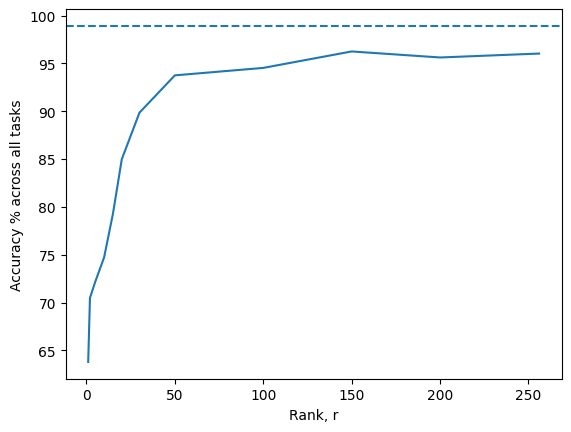

In [10]:
import matplotlib.pyplot as plt
import numpy as np

regular_vcl = np.array([98.48, 93.34, 99.15, 98.69, 97.58, 97.42])
rank_256 = np.array([99.81, 93.49, 94.66, 97.18, 94.81, 96.04])
rank_200 = np.array([99.9, 94.52, 92.05, 97.33, 93.9, 95.63])
rank_150 = np.array([99.95, 93.78, 96.1, 97.63, 93.49, 96.26])
rank_100 = np.array([99.95, 94.86, 92.68, 96.32, 88.4, 94.54])
rank_50 = np.array([99.91, 90.4, 94.34, 97.48, 86.38, 93.76])
rank_30 = np.array([99.95, 91.97, 87.94, 84.64, 83.96, 89.86])
rank_20 = np.array([99.95, 79.33, 79.67, 86.91, 77.96, 84.99])
rank_15 = np.array([99.95, 86.53, 79.72, 56.29, 75.29, 79.29])
rank_10 = np.array([99.95, 66.79, 67.34, 71.4, 66.26, 74.72])
rank_5 = np.array([99.95, 70.81, 51.6, 65.91, 69.69, 72.18])
rank_2 = np.array([99.95, 62.44, 59.55, 63.65, 64.55, 70.49])
rank_1 = np.array([99.95, 50.54, 52.4, 54.13, 59.34, 63.79])

data = np.vstack((rank_1, rank_2, rank_5, rank_10, rank_15, rank_20, rank_30, rank_50, rank_100, rank_150, rank_200, rank_256))
print(data[:,-1])
ranks = np.array([1, 2, 5, 10, 15, 20, 30, 50, 100, 150, 200, 256])
plt.plot(ranks, data[:,-1])
plt.xlabel("Rank, r")
plt.ylabel("Accuracy % across all tasks")
plt.axhline(98.93, linestyle='--')